In [4]:
#Code taken from/inspired by:
#https://www.geeksforgeeks.org/working-zip-files-python/
#https://stackabuse.com/the-naive-bayes-algorithm-in-python-with-scikit-learn/
#https://stackabuse.com/understanding-roc-curves-with-python/
#https://towardsdatascience.com/encoding-categorical-features-21a2651a065c
#https://towardsdatascience.com/cross-validation-explained-evaluating-estimator-performance-e51e5430ff85
#https://medium.com/@svanillasun/how-to-deal-with-cross-validation-based-on-knn-algorithm-compute-auc-based-on-naive-bayes-ff4b8284cff4
#https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/

import zipfile
import os
import requests
import pandas as pd
import numpy as np


def download_zip(url):

    data = requests.get(url).content
    filename = os.path.basename(url)
    with open(filename, "wb") as file:
        file.write(data)

url="https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"
download_zip(url)
        

def extract_zip(filepath):
    zfile = zipfile.ZipFile(filepath)
    for finfo in zfile.infolist():
        zfile.extractall()
        
extract_zip("bank-additional.zip")


col_names=['age', 'job', 'marital', 'education', 'default','housing','loan','contact','month','day','duration','campaign',
           'pdays','previous','poutcome','emp_var_rate','cons_price_idx','cons_conf_idx','euribor3m','nr_employed','y']

feature_cols=['age', 'job', 'marital', 'education', 'default','housing','loan','contact','month','day','duration','campaign',
           'pdays','previous','poutcome','emp_var_rate','cons_price_idx','cons_conf_idx','euribor3m','nr_employed']

data= pd.read_table('bank-additional/bank-additional.csv', sep=';', header=None,names=col_names)

data=data.drop([0],axis=0) #removing row with column names



In [5]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

X=data[feature_cols]
y=data['y']

X = pd.get_dummies(X, prefix_sep='_', drop_first=True)
y = pd.get_dummies(y, prefix_sep='_', drop_first=True)
y=np.ravel(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)

model = MultinomialNB().fit(X_train, y_train)
predicted = model.predict(X_test)
    


[[1008   88]
 [  68   72]]
Accuracy: 0.8737864077669902
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1096
           1       0.45      0.51      0.48       140

   micro avg       0.87      0.87      0.87      1236
   macro avg       0.69      0.72      0.70      1236
weighted avg       0.88      0.87      0.88      1236

AUC: 0.82


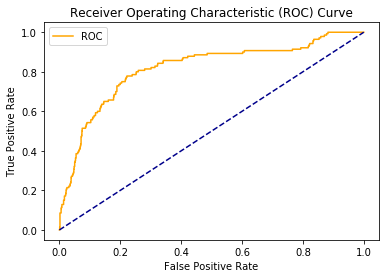

In [6]:


from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score,accuracy_score
import matplotlib.pyplot as plt

print(confusion_matrix(y_test, predicted))
print("Accuracy:", accuracy_score(predicted,y_test))
print(classification_report(y_test, predicted))

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

probs=model.predict_proba(X_test)
probs=probs[:,1] #extracting probabilites for class 'yes'
fpr,tpr,thresholds=roc_curve(y_test, probs, sample_weight=None, drop_intermediate=True)
auc = roc_auc_score(y_test, probs)

print('AUC: %.2f' % auc)

plot_roc_curve(fpr,tpr)


In [7]:
#Using K-fold

from sklearn.model_selection import KFold, cross_val_score

model = MultinomialNB()
kfold_accuracy = cross_val_score(model, X, y, scoring='accuracy', cv = 5)

print(kfold_accuracy)
#get the mean of each fold 
print("Mean accuracy kfold:", kfold_accuracy.mean())

# LOO
from sklearn.model_selection import LeaveOneOut

loocv = LeaveOneOut()
loocv_accuracy = cross_val_score(model, X, y, cv=loocv)
print("Mean accuracy LOO:", (loocv_accuracy.mean()))


[0.87636364 0.85558252 0.875      0.87484812 0.88699878]
Mean accuracy kfold: 0.8737586124430136
Mean accuracy LOO: 0.8735129885894635


In [9]:
# KNN

#determining best k

from sklearn.neighbors import KNeighborsClassifier

k_range = range(1, 15)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())
    
print(k_scores)
print("Best k:", k_scores.index(max(k_scores)) + 1)


[0.8504499572277888, 0.8900225221698757, 0.8815235411601655, 0.8941508037708182, 0.8939092628558825, 0.892935737657098, 0.8943944048299531, 0.8965788737091925, 0.8956097672927175, 0.8963364494667683, 0.8953664575779381, 0.8936653654477033, 0.8931808111670325, 0.8931784553887445]
Best k: 8


[[965 142]
 [111  18]]
Accuracy: 0.7953074433656958
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      1107
           1       0.11      0.14      0.12       129

   micro avg       0.80      0.80      0.80      1236
   macro avg       0.50      0.51      0.50      1236
weighted avg       0.81      0.80      0.80      1236

AUC: 0.72


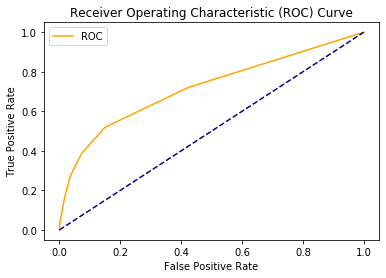

In [10]:
#30-70 split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = KNeighborsClassifier(n_neighbors=8)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, predicted))
print("Accuracy:", accuracy_score(predicted,y_test))
print(classification_report(y_test, predicted))

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

probs=model.predict_proba(X_test)
probs=probs[:,1] #extracting probabilites for class 'yes'
fpr,tpr,thresholds=roc_curve(y_test, probs, sample_weight=None, drop_intermediate=True)
auc = roc_auc_score(y_test, probs)

print('AUC: %.2f' % auc)

plot_roc_curve(fpr,tpr)



In [ ]:

# 5-fold cv

kfold_accuracy = cross_val_score(model, X, y, scoring='accuracy', cv = 5)

print(kfold_accuracy)
print("Mean accuracy kfold:", kfold_accuracy.mean())

# LOO

from sklearn.model_selection import LeaveOneOut

loocv = LeaveOneOut()
loocv_accuracy = cross_val_score(model, X, y, cv=loocv)
print("Mean accuracy LOO:", (loocv_accuracy.mean()))

[0.89090909 0.90048544 0.89563107 0.89671932 0.89914945]
Mean accuracy kfold: 0.8965788737091925
